# Air Quality Prediction - Data Understanding and Preprocessing

## Approach
Based on the EDA, we'll focus on 5 cities with the least missing values:
- Hyderabad
- Chennai
- Lucknow
- Bengaluru 
- Delhi

In this notebook, we'll focus on:
1. Understanding the data characteristics
2. Cleaning and preprocessing the data
3. Handling missing values
4. Feature engineering
5. Preparing data for time series modeling

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Inspection

In [21]:
# Load the merged dataset
data_path = '../data/merged_weather_air_quality.csv'
df = pd.read_csv(data_path)

# Drop redundant city columns and irrelevant columns
df = df.drop(['City_x', 'City_y', 'snow', 'snowdepth', 'preciptype', 'severerisk', 'stations'], axis=1)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / (1024**2):.2f} MB")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (29418, 45)
Memory usage: 10.10 MB

First 5 rows:


,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,...,sunrise,sunset,moonphase,conditions,description,icon,city,TropoO3,OMIO3,StratoO3
0,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,...,2015-01-01T07:20:36,2015-01-01T18:05:22,0.36,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,ahmedabad,NaN,NaN,221.254115
1,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,...,2015-01-02T07:20:54,2015-01-02T18:06:00,0.40,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,ahmedabad,6.412035,251.081230,248.519194
2,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,...,2015-01-03T07:21:11,2015-01-03T18:06:39,0.43,Clear,Clear conditions throughout the day.,clear-day,ahmedabad,NaN,NaN,221.543318
3,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,...,2015-01-04T07:21:27,2015-01-04T18:07:19,0.47,Clear,Clear conditions throughout the day.,clear-day,ahmedabad,10.745185,259.409378,248.664193
4,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,...,2015-01-05T07:21:41,2015-01-05T18:07:59,0.50,Clear,Clear conditions throughout the day.,clear-day,ahmedabad,NaN,NaN,233.666427


In [22]:
df.columns

Index(['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'city', 'TropoO3',
       'OMIO3', 'StratoO3'],
      dtype='object')

In [23]:
# Check columns and their data types
print("Column data types:")
df.dtypes

Column data types:


Date                 object
PM2.5               float64
PM10                float64
NO                  float64
NO2                 float64
NOx                 float64
NH3                 float64
CO                  float64
SO2                 float64
O3                  float64
Benzene             float64
Toluene             float64
Xylene              float64
AQI                 float64
AQI_Bucket           object
tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
precipcover         float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
sunrise             

In [24]:
# Check unique cities in the dataset
cities = df['city'].unique()
print(f"Number of unique cities: {len(cities)}")
print("Cities in the dataset:")
cities

Number of unique cities: 25
Cities in the dataset:


array(['ahmedabad', 'amaravati', 'amritsar', 'bengaluru', 'bhopal',
       'brajrajnagar', 'chandigarh', 'chennai', 'coimbatore', 'delhi',
       'ernakulam', 'gurugram', 'guwahati', 'hyderabad', 'jaipur',
       'jorapokhar', 'kochi', 'kolkata', 'lucknow', 'mumbai', 'patna',
       'shillong', 'talcher', 'thiruvananthapuram', 'visakhapatnam'],
      dtype=object)

In [25]:
# Check the date range for our dataset
df['Date'] = pd.to_datetime(df['Date'])
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Check for any duplicates
duplicates = df.duplicated(subset=['city', 'Date']).sum()
print(f"Number of duplicated city-date combinations: {duplicates}")

Date range: 2015-01-01 00:00:00 to 2020-07-01 00:00:00
Number of duplicated city-date combinations: 0


## 2. Data Quality Assessment

In [26]:
# Check for missing values across all columns
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Columns with missing values:")
missing_df[missing_df['Missing Values'] > 0]

Columns with missing values:


,Missing Values,Percentage
Xylene,17996,61.17
TropoO3,11916,40.51
OMIO3,11341,38.55
PM10,11139,37.86
NH3,10328,35.11
Toluene,8026,27.28
Benzene,5608,19.06
AQI_Bucket,4679,15.91
AQI,4679,15.91
PM2.5,4596,15.62


In [27]:
# Filter for the five cities with least missing values
target_cities = ['hyderabad', 'chennai', 'lucknow', 'bengaluru', 'delhi']
df_filtered = df[df['city'].str.lower().isin([city.lower() for city in target_cities])]

# Check the distribution of data by city
city_counts = df_filtered['city'].value_counts()
print("Data distribution by city:")
city_counts

Data distribution by city:


city
bengaluru    2009
chennai      2009
delhi        2009
lucknow      2009
hyderabad    2006
Name: count, dtype: int64

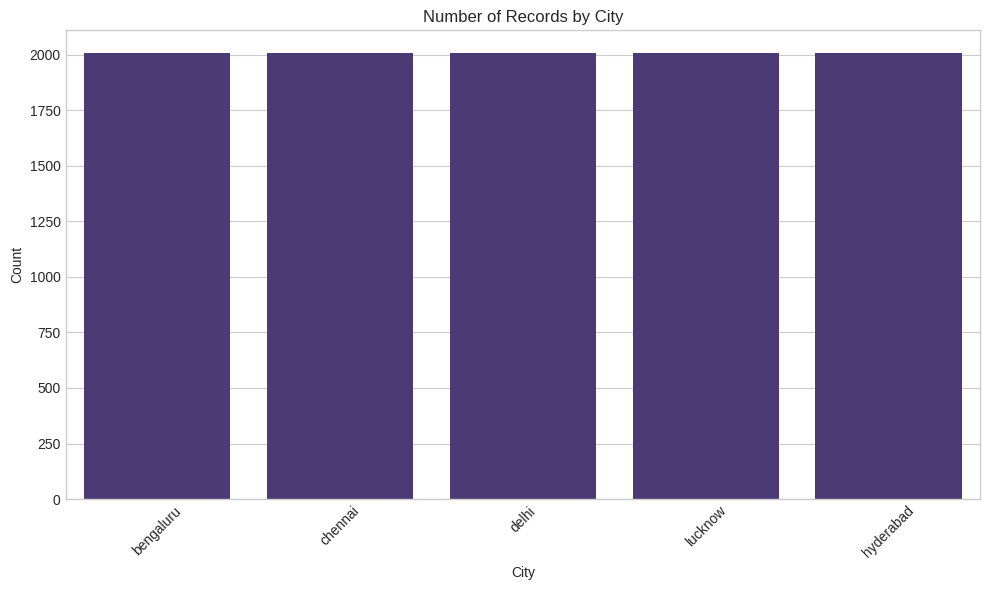

In [28]:
# Visualize the distribution of data by city
plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title('Number of Records by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Check missing values for AQI by city (our target variable)
missing_aqi_by_city = df_filtered.groupby('city').apply(lambda x: x['AQI'].isnull().sum())
total_by_city = df_filtered.groupby('city').size()
missing_percentage = (missing_aqi_by_city / total_by_city * 100).round(2)

missing_summary = pd.DataFrame({
    'Total Records': total_by_city,
    'Missing AQI': missing_aqi_by_city,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage')

print("Missing AQI values by city:")
print(missing_summary)

Missing AQI values by city:
           Total Records  Missing AQI  Missing Percentage
city                                                     
delhi               2009           10                0.50
bengaluru           2009           99                4.93
lucknow             2009          116                5.77
chennai             2009          125                6.22
hyderabad           2006          126                6.28


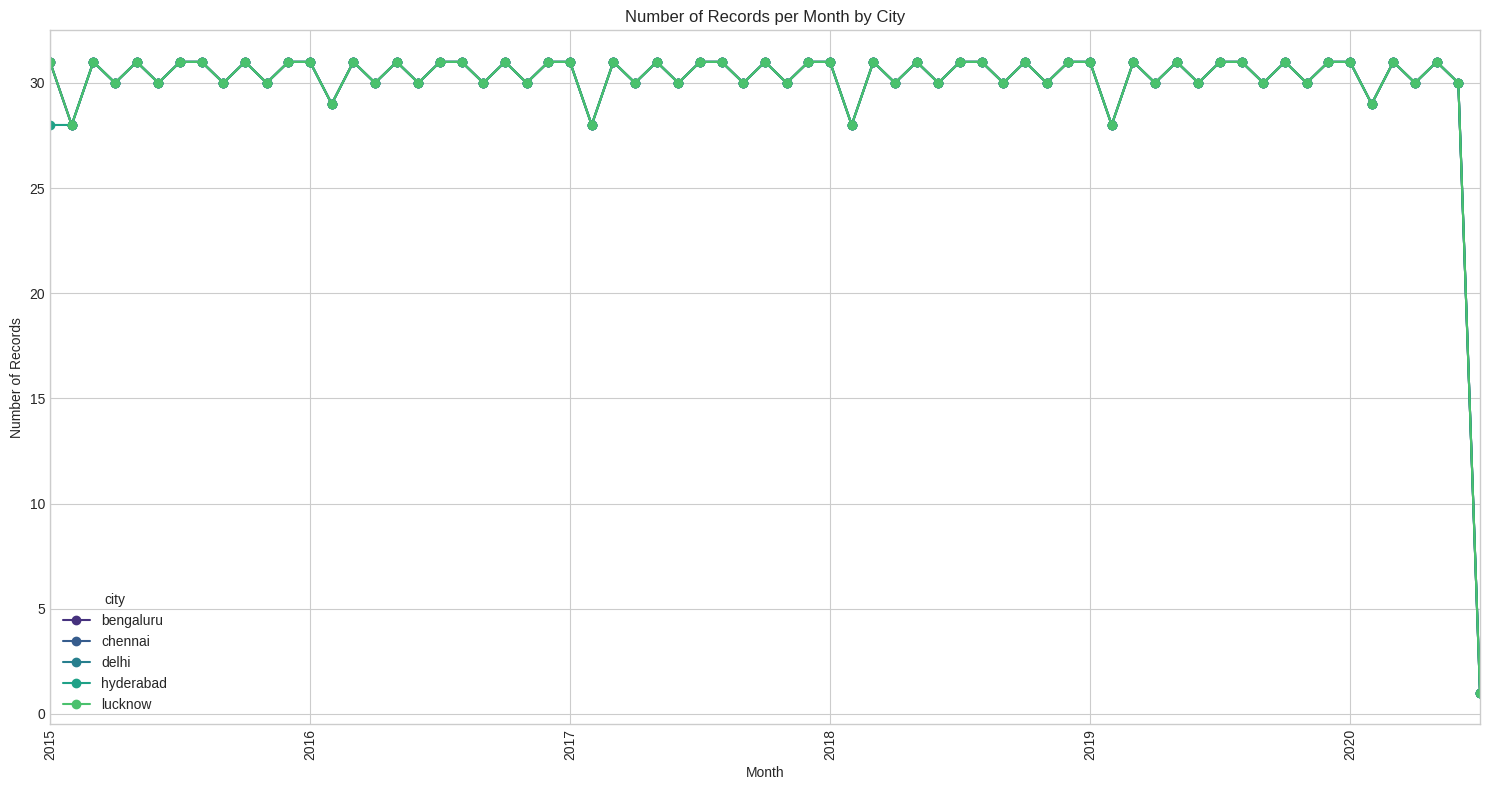

In [31]:
# Check data completeness over time
df_filtered['year_month'] = df_filtered['Date'].dt.to_period('M')

# Count records per month per city
monthly_counts = df_filtered.groupby(['city', 'year_month']).size().unstack(level=0).fillna(0)

# Visualize data completeness
plt.figure(figsize=(15, 8))
monthly_counts.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Number of Records per Month by City')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Feature Selection

In [32]:
# Select relevant features
# Weather features
weather_features = [
    'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
    'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
    'solarradiation', 'solarenergy', 'uvindex'
]

# Air quality features (excluding AQI itself which is our target)
air_quality_features = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
    'Benzene', 'Toluene', 'Xylene'
]

# Ozone features
ozone_features = ['TropoO3', 'OMIO3', 'StratoO3']

# Metadata
metadata_features = ['city', 'Date']

# Target variable
target = 'AQI'

# Create a list of features to keep
selected_features = metadata_features + weather_features + air_quality_features + ozone_features + [target]

# Keep only the selected features
df_selected = df_filtered[selected_features].copy()

In [33]:
# Check missing values in the selected features
missing_selected = df_selected.isnull().sum().sort_values(ascending=False)
missing_pct_selected = (missing_selected / len(df_selected) * 100).round(2)
missing_selected_df = pd.DataFrame({
    'Missing Values': missing_selected,
    'Percentage': missing_pct_selected
})

print("Missing values in selected features:")
missing_selected_df[missing_selected_df['Missing Values'] > 0]

Missing values in selected features:


,Missing Values,Percentage
Xylene,6935,69.06
PM10,4508,44.89
TropoO3,4071,40.54
OMIO3,3829,38.13
NH3,2038,20.29
StratoO3,1353,13.47
Benzene,777,7.74
Toluene,609,6.06
PM2.5,482,4.80
AQI,476,4.74


## 4. Exploring Target Variable (AQI)

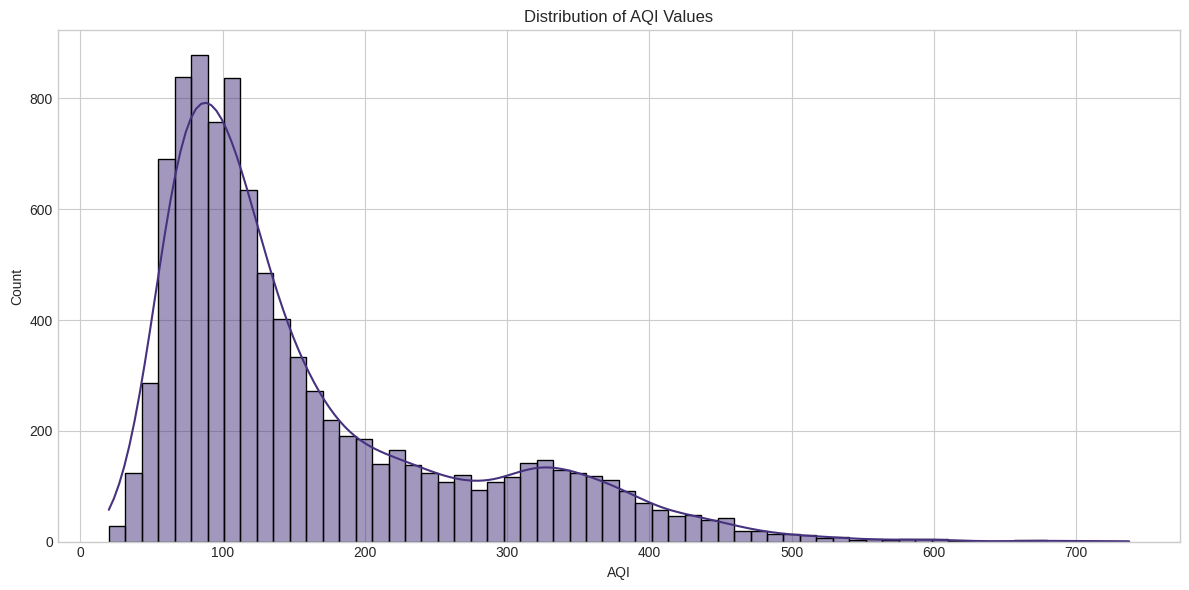

In [34]:
# Plot AQI distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_selected['AQI'].dropna(), kde=True)
plt.title('Distribution of AQI Values')
plt.xlabel('AQI')
plt.tight_layout()
plt.show()

In [35]:
# AQI statistics by city
aqi_stats = df_selected.groupby('city')['AQI'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
print("AQI statistics by city:")
aqi_stats

AQI statistics by city:


,mean,median,min,max,std
city,,,,,
bengaluru,94.32,86.0,20.0,352.0,39.91
chennai,114.50,100.0,30.0,449.0,51.97
delhi,259.49,257.0,29.0,716.0,119.54
hyderabad,109.21,104.0,22.0,737.0,53.14
lucknow,217.97,198.0,39.0,707.0,116.96


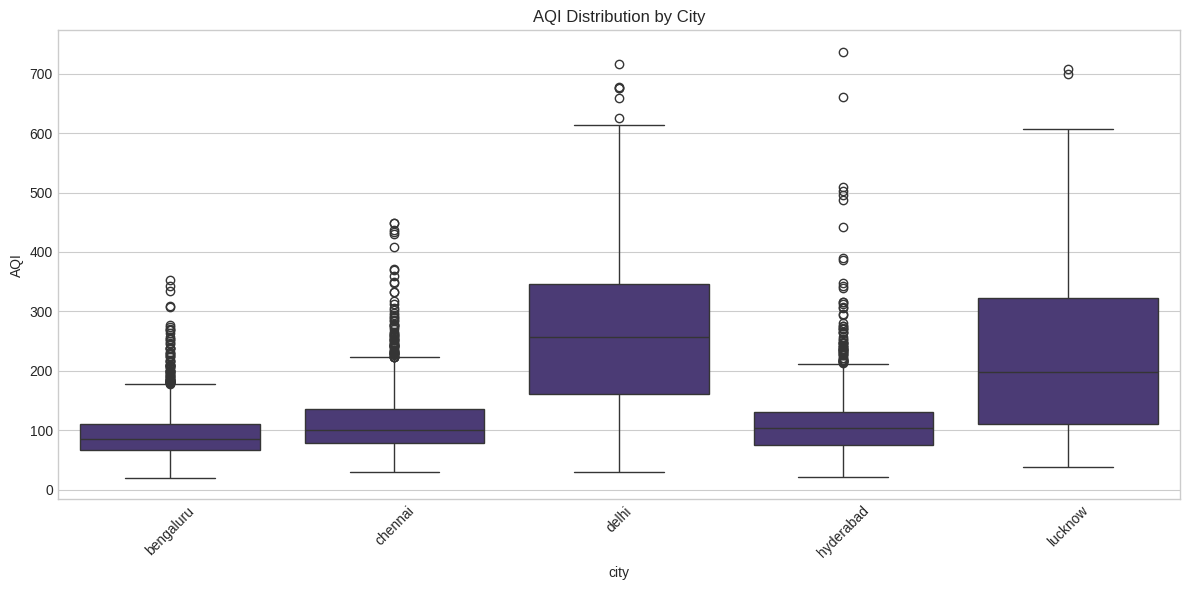

In [36]:
# Visualize AQI by city
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='AQI', data=df_selected)
plt.title('AQI Distribution by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

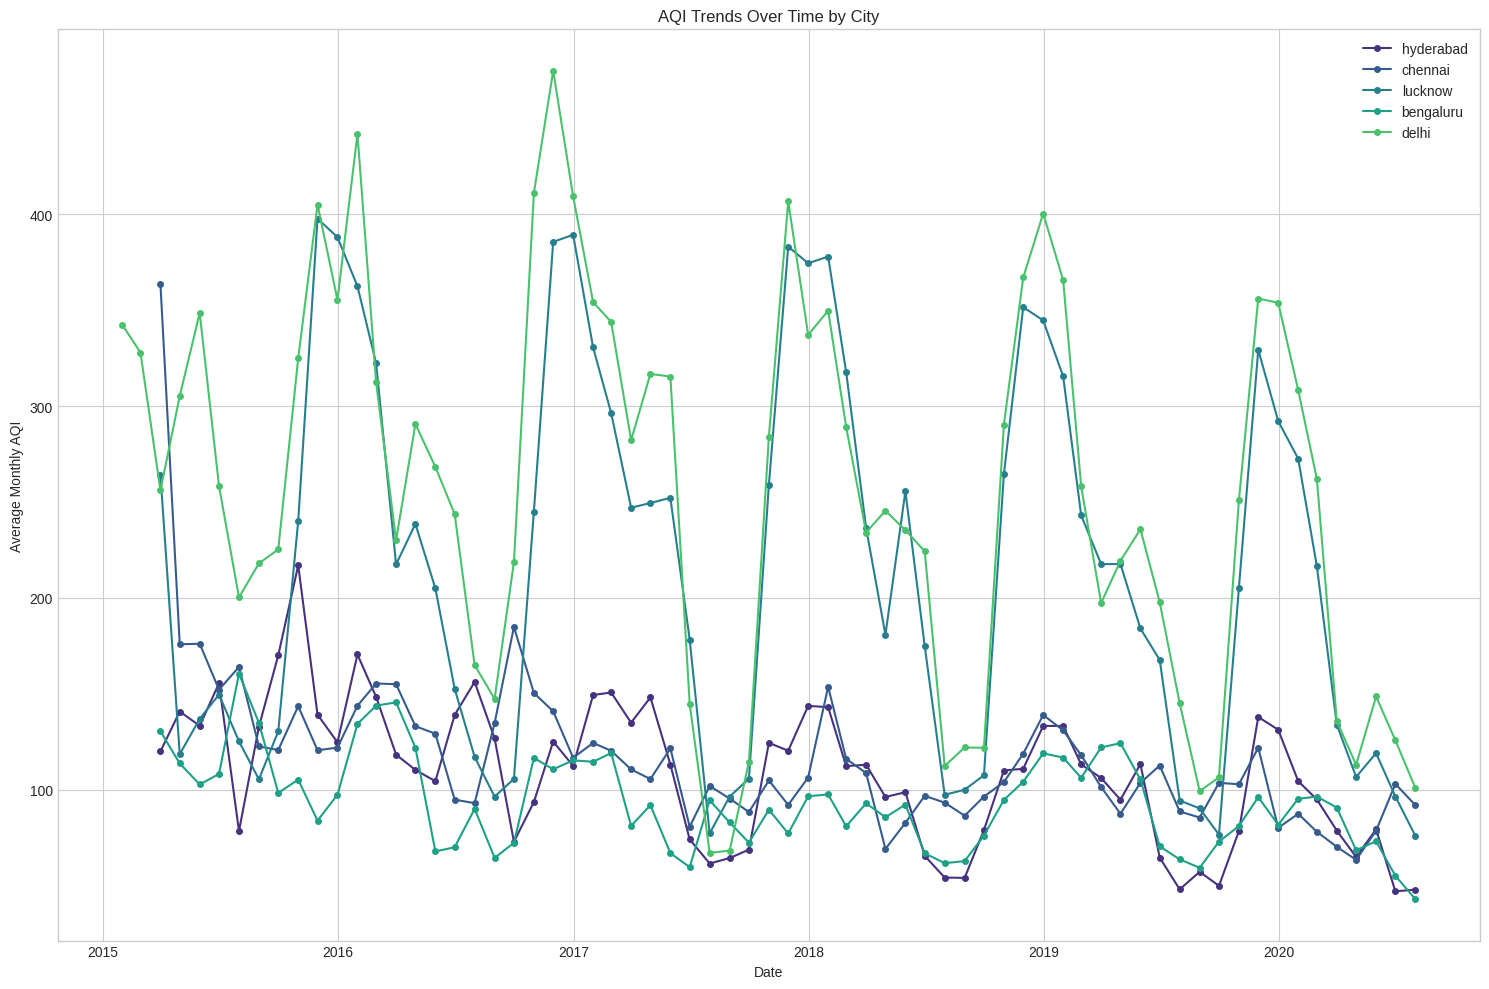

In [37]:
# Visualize AQI trends over time for each city
plt.figure(figsize=(15, 10))

for city in target_cities:
    city_data = df_selected[df_selected['city'].str.lower() == city.lower()]
    # Resample to monthly for better visualization
    city_monthly = city_data.set_index('Date')['AQI'].resample('M').mean()
    plt.plot(city_monthly.index, city_monthly.values, label=city, marker='o', markersize=4)

plt.title('AQI Trends Over Time by City')
plt.xlabel('Date')
plt.ylabel('Average Monthly AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Handling Missing Values

In [44]:
# First, separate metadata columns from features
features_to_impute = [col for col in df_selected.columns if col not in ['city', 'Date', target]]

# Create a copy to work with
df_imputed = df_filtered.copy()

# Drop columns with high missing values
columns_to_drop = ['Xylene', 'TropoO3', 'OMIO3']
df_imputed = df_imputed.drop(columns=columns_to_drop)

# Update features_to_impute to exclude dropped columns
features_to_impute = [col for col in features_to_impute if col not in columns_to_drop]

print("Number of features to impute:", len(features_to_impute))
print("Features to impute:", features_to_impute)

# First, drop rows where AQI is missing (our target variable)
print(f"\nShape before dropping rows with missing AQI: {df_imputed.shape}")
df_imputed = df_imputed.dropna(subset=[target])
print(f"Shape after dropping rows with missing AQI: {df_imputed.shape}")

# Use KNN imputation for city-specific imputation
for city in df_imputed['city'].unique():
    # Get data for this city only
    city_data = df_imputed[df_imputed['city'] == city].copy()
    
    # Sort by date to ensure temporal ordering for KNN
    city_data = city_data.sort_values('Date')
    
    # Separate features from metadata
    features_city_data = city_data[features_to_impute]
    
    # Print debugging information
    print(f"\nCity: {city}")
    print(f"Features shape before imputation: {features_city_data.shape}")
    
    if city.lower() == 'lucknow':
        # Check for columns with all missing values or no variation
        null_counts = features_city_data.isnull().sum()
        print("\nMissing value counts for Lucknow:")
        print(null_counts[null_counts > 0])
        
        # Check for columns with no variation
        variance = features_city_data.var()
        print("\nColumns with zero variance:")
        print(variance[variance == 0])
    
    # Only perform imputation if there are any missing values
    if features_city_data.isnull().sum().sum() > 0:
        # Remove any columns with all missing values before imputation
        cols_to_impute = features_city_data.columns[features_city_data.isnull().mean() < 1.0]
        features_for_imputation = features_city_data[cols_to_impute]
        
        # Use KNN imputer with a small number of neighbors
        imputer = KNNImputer(n_neighbors=5)
        imputed_data = imputer.fit_transform(features_for_imputation)
        
        print(f"Imputed data shape: {imputed_data.shape}")
        
        # Create DataFrame with the imputed data
        imputed_df = pd.DataFrame(
            imputed_data, 
            columns=cols_to_impute,
            index=city_data.index
        )
        
        # Update the original DataFrame one column at a time
        for col in cols_to_impute:
            df_imputed.loc[city_data.index, col] = imputed_df[col]

# Check if any missing values remain
print("\nMissing values after imputation:")
missing_after = df_imputed.isnull().sum()
print(missing_after[missing_after > 0])

Number of features to impute: 27
Features to impute: ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'StratoO3']

Shape before dropping rows with missing AQI: (10042, 43)
Shape after dropping rows with missing AQI: (9566, 43)

City: bengaluru
Features shape before imputation: (1910, 27)
Imputed data shape: (1910, 27)

City: chennai
Features shape before imputation: (1884, 27)
Imputed data shape: (1884, 27)

City: delhi
Features shape before imputation: (1999, 27)
Imputed data shape: (1999, 27)

City: hyderabad
Features shape before imputation: (1880, 27)
Imputed data shape: (1880, 27)

City: lucknow
Features shape before imputation: (1893, 27)

Missing value counts for Lucknow:
PM2.5          2
PM10        1893
NO             2
NO2            2
NOx         

In [45]:
# If there are still missing values in the target, we'll drop those rows
# We want to keep our target clean for training
print(f"Shape before dropping rows with missing AQI: {df_imputed.shape}")
df_imputed = df_imputed.dropna(subset=[target])
print(f"Shape after dropping rows with missing AQI: {df_imputed.shape}")

Shape before dropping rows with missing AQI: (9566, 43)
Shape after dropping rows with missing AQI: (9566, 43)


## 6. Feature Engineering

In [46]:
# Feature engineering
# Add date-based features
df_imputed['year'] = df_imputed['Date'].dt.year
df_imputed['month'] = df_imputed['Date'].dt.month
df_imputed['day'] = df_imputed['Date'].dt.day
df_imputed['dayofweek'] = df_imputed['Date'].dt.dayofweek
df_imputed['season'] = df_imputed['month'].apply(lambda x: 
    'Winter' if x in [12, 1, 2] else 
    'Spring' if x in [3, 4, 5] else 
    'Summer' if x in [6, 7, 8] else 'Fall')

# Create categorical features
df_imputed = pd.get_dummies(df_imputed, columns=['season'], drop_first=True)

# Display the new dataset shape
print(f"Shape after feature engineering: {df_imputed.shape}")
df_imputed.head()

Shape after feature engineering: (9566, 50)


,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,...,city,StratoO3,year_month,year,month,day,dayofweek,season_Spring,season_Summer,season_Winter
4260,2015-03-21,48.59,92.564,3.47,27.00,18.04,28.02,3.89,1.94,52.96,...,bengaluru,227.738576,2015-03,2015,3,21,5,True,False,False
4261,2015-03-22,47.38,92.564,2.84,22.39,15.33,23.19,11.29,2.05,71.85,...,bengaluru,228.526436,2015-03,2015,3,22,6,True,False,False
4262,2015-03-23,65.65,99.270,3.10,26.35,17.45,27.76,9.95,6.30,72.84,...,bengaluru,270.132683,2015-03,2015,3,23,0,True,False,False
4263,2015-03-24,60.47,95.752,5.39,29.87,20.88,35.10,1.46,6.07,64.12,...,bengaluru,188.521630,2015-03,2015,3,24,1,True,False,False
4264,2015-03-25,62.56,89.940,3.16,23.57,16.39,27.13,10.05,4.98,82.34,...,bengaluru,244.704224,2015-03,2015,3,25,2,True,False,False


## 7. Creating Lag Features for Time Series Modeling

In [47]:
# Sort data by city and date
df_imputed = df_imputed.sort_values(['city', 'Date'])

# Create lagged features for time series modeling
# For each city, create lagged features of important air quality and weather variables

# List of features to create lags for
lag_features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'temp', 'humidity', 'windspeed', 'AQI']

# Number of days to lag
lag_days = [1, 2, 3, 7]  # 1, 2, 3 days and 1 week

# Create a new dataframe to store the data with lags
df_with_lags = df_imputed.copy()

# Create lag features for each city separately
for city in df_with_lags['city'].unique():
    city_mask = df_with_lags['city'] == city
    city_data = df_with_lags[city_mask].copy()
    
    # Sort by date
    city_data = city_data.sort_values('Date')
    
    # Create lag features
    for feature in lag_features:
        for lag in lag_days:
            lag_name = f"{feature}_lag_{lag}"
            city_data[lag_name] = city_data[feature].shift(lag)
    
    # Update the main dataframe
    df_with_lags.loc[city_mask] = city_data

# Drop rows with NaN values created by the lag operation
df_with_lags = df_with_lags.dropna()

# Display the new dataset shape
print(f"Shape after creating lag features: {df_with_lags.shape}")
print(f"Number of features: {df_with_lags.shape[1]}")
df_with_lags.head()

Shape after creating lag features: (7673, 50)
Number of features: 50


,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,...,city,StratoO3,year_month,year,month,day,dayofweek,season_Spring,season_Summer,season_Winter
4260,2015-03-21,48.59,92.564,3.47,27.00,18.04,28.02,3.89,1.94,52.96,...,bengaluru,227.738576,2015-03,2015,3,21,5,True,False,False
4261,2015-03-22,47.38,92.564,2.84,22.39,15.33,23.19,11.29,2.05,71.85,...,bengaluru,228.526436,2015-03,2015,3,22,6,True,False,False
4262,2015-03-23,65.65,99.270,3.10,26.35,17.45,27.76,9.95,6.30,72.84,...,bengaluru,270.132683,2015-03,2015,3,23,0,True,False,False
4263,2015-03-24,60.47,95.752,5.39,29.87,20.88,35.10,1.46,6.07,64.12,...,bengaluru,188.521630,2015-03,2015,3,24,1,True,False,False
4264,2015-03-25,62.56,89.940,3.16,23.57,16.39,27.13,10.05,4.98,82.34,...,bengaluru,244.704224,2015-03,2015,3,25,2,True,False,False


## 8. Data Splitting Strategy for Time Series

In [48]:
# Function to create train/test splits for each city
def create_city_splits(city_data, test_size=0.2, val_size=0.15):
    # Sort by date
    city_data = city_data.sort_values('Date')
    
    # Calculate split points
    n = len(city_data)
    test_idx = int(n * (1 - test_size))
    val_idx = int(n * (1 - test_size - val_size))
    
    # Create splits
    train = city_data.iloc[:val_idx]
    val = city_data.iloc[val_idx:test_idx]
    test = city_data.iloc[test_idx:]
    
    return train, val, test

# Create dictionaries to store the splits for each city
train_dfs = {}
val_dfs = {}
test_dfs = {}

# Create splits for each city
for city in df_with_lags['city'].unique():
    city_data = df_with_lags[df_with_lags['city'] == city].copy()
    train, val, test = create_city_splits(city_data)
    
    train_dfs[city] = train
    val_dfs[city] = val
    test_dfs[city] = test
    
    print(f"City: {city}")
    print(f"  Train period: {train['Date'].min()} to {train['Date'].max()}, Shape: {train.shape}")
    print(f"  Validation period: {val['Date'].min()} to {val['Date'].max()}, Shape: {val.shape}")
    print(f"  Test period: {test['Date'].min()} to {test['Date'].max()}, Shape: {test.shape}")
    print()

City: bengaluru
  Train period: 2015-03-21 00:00:00 to 2018-09-01 00:00:00, Shape: (1241, 50)
  Validation period: 2018-09-02 00:00:00 to 2019-06-15 00:00:00, Shape: (287, 50)
  Test period: 2019-06-16 00:00:00 to 2020-07-01 00:00:00, Shape: (382, 50)

City: chennai
  Train period: 2015-03-24 00:00:00 to 2018-09-10 00:00:00, Shape: (1224, 50)
  Validation period: 2018-09-11 00:00:00 to 2019-06-20 00:00:00, Shape: (283, 50)
  Test period: 2019-06-21 00:00:00 to 2020-07-01 00:00:00, Shape: (377, 50)

City: delhi
  Train period: 2015-01-01 00:00:00 to 2018-08-01 00:00:00, Shape: (1299, 50)
  Validation period: 2018-08-02 00:00:00 to 2019-05-28 00:00:00, Shape: (300, 50)
  Test period: 2019-05-29 00:00:00 to 2020-07-01 00:00:00, Shape: (400, 50)

City: hyderabad
  Train period: 2015-03-31 00:00:00 to 2018-09-12 00:00:00, Shape: (1222, 50)
  Validation period: 2018-09-13 00:00:00 to 2019-06-21 00:00:00, Shape: (282, 50)
  Test period: 2019-06-22 00:00:00 to 2020-07-01 00:00:00, Shape: (376,

## 9. Save Processed Data for Modeling

In [49]:
# Create a directory for processed data if it doesn't exist
import os
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Save the processed datasets
df_with_lags.to_csv(f'{processed_dir}/processed_data_with_lags.csv', index=False)

# Save the train/val/test splits by city
for city in train_dfs.keys():
    city_dir = f'{processed_dir}/{city.lower()}'
    if not os.path.exists(city_dir):
        os.makedirs(city_dir)
        
    train_dfs[city].to_csv(f'{city_dir}/train.csv', index=False)
    val_dfs[city].to_csv(f'{city_dir}/val.csv', index=False)
    test_dfs[city].to_csv(f'{city_dir}/test.csv', index=False)

print("Datasets saved successfully.")

Datasets saved successfully.


## 10. Summary of Data Preparation

In this notebook, we have:

1. **Data Understanding**: Loaded and explored the merged air quality and weather dataset
2. **Data Cleaning**: Filtered for the 5 cities with the best data quality
3. **Missing Value Handling**: Used KNN imputation specific to each city's time series
4. **Feature Engineering**: 
   - Created temporal features (year, month, day, season)
   - Generated lag features for time series modeling
5. **Train/Val/Test Split**: Created chronological splits for each city's data
6. **Data Saving**: Saved processed data for the modeling stage

Next steps would involve building and comparing different predictive models for AQI.